# Tree-Ring Watermarking: Invisible Fingerprints in Diffusion Models

**Tree-Ring Watermarking** is a method for embedding invisible, robust watermarks into images generated by diffusion models. The technique modifies the *initial noise vector* in **Fourier space** before sampling begins, rather than altering the image afterward.

This ensures the watermark is:
-  **Invisible**: no post-processing artifacts,
-  **Robust**: invariant to common distortions (crop, rotate, JPEG, etc.),
-  **Detectable**: via inversion using the original diffusion model (e.g., DDIM).

---

### Basic Concept

Let $x_T \in \mathbb{R}^{C \times H \times W}$ be the initial Gaussian noise used to generate an image with a diffusion model.

We modify it in **Fourier space**:

$$
\mathcal{F}(x_T)_i =
\begin{cases}
k^*_i & \text{if } i \in \mathcal{M} \\
\mathcal{N}(0, 1) & \text{otherwise}
\end{cases}
$$

- $\mathcal{F}$ is the 2D Fourier transform (with shift),
- $\mathcal{M}$ is a mask (e.g. a ring around the center),
- $k^*$ is the **watermark key** inserted into that region.

After watermarking, we generate the image $x_0$ using the diffusion model:

$$
x_0 = D_\theta(x_T)
$$

To detect the watermark, we use **DDIM inversion**:

$$
x_T' = D_\theta^\dagger(x_0)
$$

Then we compute the **detection distance** (e.g., L1) in the masked Fourier region:

$$
\text{distance} = \frac{1}{|\mathcal{M}|} \sum_{i \in \mathcal{M}} \left| \mathcal{F}(x_T')_i - k^*_i \right|
$$

If this distance is below a threshold $\tau$, we conclude the image is watermarked.

---

### Why "Tree-Ring"?

The watermark pattern is often composed of **concentric rings** in Fourier space — similar to growth rings in a tree cross-section. This structure offers:
- **Rotational invariance**,
- **Robustness to spatial distortions**,
- **Statistical similarity to Gaussian noise** when properly designed.

---

In this notebook, we will:
1. Generate synthetic noise and a tree-ring pattern,
2. Embed the watermark into the noise,
3. Simulate forward and inverse diffusion,
4. Detect the watermark using the simplified detection formula above.

We assume you’re already familiar with how diffusion models work, and what DDIM is.

---

## Pretrained Diffusion Model

In this demo, we use the **pretrained diffusion model** provided by [OpenAI's Guided Diffusion repository](https://github.com/openai/guided-diffusion).

Specifically, we use the **256×256 class-conditional diffusion model trained on ImageNet**. This model is based on a large UNet architecture trained to reverse Gaussian noise into realistic images.

- It supports **DDPM** and **DDIM** sampling.
- It operates in **pixel space** rather than latent space.
- It accepts an optional **class label** as input (e.g., "dog", "car").

This model is ideal for our purposes because it:
- Allows us to inject a watermark directly into the **initial noise**,
- Supports **DDIM inversion**, which is essential for watermark detection,
- Is open-sourced and well-documented for reproducible research.

We do not retrain the model — instead, we treat it as a **frozen black box** that maps noise to image and image back to noise.



# 1. Prepare model and dataset

In [1]:
# Watermarking parameters
w_seed = 999999
w_channel = -1
w_pattern = 'rand' 
w_mask_shape = 'circle'
w_radius = 30
w_measurement = 'l1_complex'
w_injection = 'complex'
w_pattern_const  = 0

Certainly! Here's a more detailed and technical extension of your original paragraph that explains the **functionality of each class and each key function** in `inverse_stable_diffusion.py` and `modified_stable_diffusion.py`:

---

With the help of custom scripts from Tree-Ring (`inverse_stable_diffusion.py` and `modified_stable_diffusion.py`), we extend the capabilities of the Stable Diffusion 2.1 model to support not only standard image generation from text prompts, but also **fine-grained latent space manipulation and DDIM inversion**. These enhancements are encapsulated in two custom pipeline classes:

---

## `ModifiedStableDiffusionPipeline`

This class subclasses Hugging Face's `StableDiffusionPipeline` and adds **custom functionality to support latent-level watermarking**, latent inspection, and extended output.

### Key Functionalities:

* **`__call__()`** **(Latent -> Image)**
  Acts as the main entry point for image generation. It supports standard prompt-to-image generation with extended arguments for Tree-Ring watermarking:

  * `watermarking_gamma`: probability mask for perturbing latents
  * `watermarking_delta`: perturbation strength
  * `watermarking_mask`: pre-defined binary mask for structured watermarking
    Additionally, it returns the original latent vector (`init_latents`) before denoising, which is critical for inversion or reconstruction workflows.

* **`get_image_latents(image, sample=True)`**
  Encodes an input image into the latent space using the VAE encoder. This function supports sampling from the distribution or returning the mode and is used for converting images back to latents prior to inversion.

---

## `InversableStableDiffusionPipeline`

This class extends `ModifiedStableDiffusionPipeline` by adding **support for DDIM inversion** (i.e., mapping from image → latent → original noise) and **prompt editing workflows**.

### Key Functionalities:

* **`backward_diffusion(...)`** **(Latent -> Image)**
  Although it's (Latent -> Image) pipeline, It's just the denoising loop, and doesn't do prompt tokenization, latent preparation, or decoding. Meanwhile, `ModifiedStableDiffusionPipeline.__call__()` is a complete, high-level pipeline that handles everything for you: prompt → latents → denoising → decoding → image + extras.
* **`forward_diffusion`** **(Image -> Latent)**
  A convenience alias (via `functools.partial`) that simply calls `backward_diffusion(reverse_process=True)` to perform a forward diffusion pass that is structurally consistent with the inversion routine.

* **`get_random_latents(...)`**
  Generates or returns random Gaussian latents suitable for input to the diffusion model, given image dimensions and device context.

* **`get_text_embedding(prompt)`**
  Tokenizes and encodes a text prompt into the text embedding space using the model’s tokenizer and text encoder. This is used to retrieve `encoder_hidden_states` for both generation and inversion.

---

Together, these classes provide a flexible, modular interface for the Tree-Ring watermarking framework, enabling researchers to:

* Embed watermarks by perturbing selected latent variables during generation,
* Generate images conditioned on textual prompts,
* Reconstruct the latent noise used in generation via DDIM inversion,
* Perform structured prompt editing (e.g., "Prompt-to-Prompt"),
* Visualize or save intermediate latent representations for further downstream analysis.

This modular design also enables easier integration with other watermark detection, evaluation, and manipulation components, making it a powerful research and debugging tool for latent space watermarking in diffusion models.

In [2]:
# Get the model.
import torch
from diffusers import DPMSolverMultistepScheduler
from inverse_stable_diffusion import InversableStableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = InversableStableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
)
pipe = pipe.to(device)

c:\Users\mike8\anaconda3\envs\ai_env\lib\site-packages\diffusers\pipelines\pipeline_loading_utils.py:285: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-1-base via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-1-base currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-1-base is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\mike8\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-1-base\snapshots\1f758383196d38df1dfe523ddb1030f2bfab7741\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


## Dataset: `Gustavosta/Stable-Diffusion-Prompts`

For this demo, we use the publicly available dataset [`Gustavosta/Stable-Diffusion-Prompts`](https://huggingface.co/datasets/Gustavosta/stable-diffusion-prompts), hosted on Hugging Face Datasets.

This dataset contains a curated collection of **high-quality text prompts** used to guide Stable Diffusion-style image generation. The prompts are designed to elicit rich, detailed, and creative visual scenes from text-to-image models.

### Dataset Highlights
- **Text-only** dataset — each sample is a prompt string.
- Originally intended for benchmarking prompt engineering in generative models.
- Useful for evaluating conditional generation, diversity, and robustness.

### Why we use it here:
- It provides a wide variety of realistic and artistic prompts.
- It enables repeatable generation and watermarking experiments across multiple prompt types.
- It is compact and easy to use, requiring no image storage.

We use this dataset to supply the **conditioning input (prompt)** for our diffusion model when generating watermarked and non-watermarked images.


In [3]:
# Prepare the dataset
from datasets import load_dataset
dataset = load_dataset('Gustavosta/Stable-Diffusion-Prompts')['test']
prompt_key = 'Prompt'

### Example of a prompt

In [4]:
"""
The instance contains `Prompt`, which is used to generate the image.
"""
dataset[0]

{'Prompt': 'young, curly haired, redhead Natalie Portman  as a optimistic!, cheerful, giddy medieval innkeeper in a dark medieval inn. dark shadows, colorful, candle light,  law contrasts, fantasy concept art by Jakub Rozalski, Jan Matejko, and J.Dickenson'}

# 2. Prepare the watermarking pattern ($k^*$), which will be injected into the image with the mask ($\mathcal{M}$).


In [5]:
# To mimic the real-world case, we assume the prompt is unknown at the detection time.
tester_prompt = '' 
text_embeddings = pipe.get_text_embedding(tester_prompt) # Generate the text embedding for the tester prompt, which is used to get the latent from given image (test image) through the forward diffusion process.

In [6]:
text_embeddings.shape # The text embedding is a 77x1024 tensor where 77 is the number of tokens in the prompt and 1024 is the dimension of the text embedding.

torch.Size([1, 77, 1024])

In [ ]:
from utils.random import set_random_seed
import numpy as np
import copy

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*?.*?")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*?.*?")

def circle_mask(size=64, r=10, x_offset=0, y_offset=0):
    """
    Create a circular mask of given size and radius.
    Parameters:
        - size: The size of the mask (width and height).
        - r: The radius of the circle.
        - x_offset: The x-coordinate offset for the center of the circle.
        - y_offset: The y-coordinate offset for the center of the circle.
    Returns:
        - mask: A boolean mask where True values represent the circular area.

    Reference: https://stackoverflow.com/questions/69687798/generating-a-soft-circluar-mask-using-numpy-python-3
    """
    x0 = y0 = size // 2
    x0 += x_offset
    y0 += y_offset
    y, x = np.ogrid[:size, :size]
    y = y[::-1]
    return ((x - x0) ** 2 + (y - y0) ** 2) <= r**2


def get_watermarking_pattern(
    pipe,
    w_seed: int,
    w_pattern: str,
    w_radius: int,
    device: str,
    shape: tuple | None = None,
):
    """
    Generate a watermarking pattern based on the specified parameters.
    Parameters:
        - pipe: The pipeline object used for generating the watermarking pattern.
        - w_seed: The seed for random number generation.
        - w_pattern: The type of watermarking pattern to generate.
        - w_radius: The radius for the watermarking pattern.
        - device: The device to use for computation (e.g., "cuda" or "cpu").
        - shape: The shape of the watermarking pattern. If None, a random shape is used.
    Returns:
        - gt_patch: The generated watermarking pattern.

    Two important functions used here are:
        `torch.fft.fft2`: Computes the 2D discrete Fourier Transform.
        `torch.fft.fftshift`: Shifts the zero-frequency component to the center of the spectrum.
    """

    set_random_seed(w_seed)
    if shape is not None:
        gt_init = torch.randn(*shape, device=device)
    else:
        gt_init = pipe.get_random_latents()

    if "seed_ring" in w_pattern:
        gt_patch = gt_init

        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(w_radius, 0, -1):
            tmp_mask = circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask).to(device)

            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()
    elif "seed_zeros" in w_pattern:
        gt_patch = gt_init * 0
    elif "seed_rand" in w_pattern:
        gt_patch = gt_init
    elif "rand" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))
        gt_patch[:] = gt_patch[0]
    elif "zeros" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
    elif "const" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2)) * 0
        gt_patch += w_pattern_const
    elif "ring" in w_pattern:
        gt_patch = torch.fft.fftshift(torch.fft.fft2(gt_init), dim=(-1, -2))

        gt_patch_tmp = copy.deepcopy(gt_patch)
        for i in range(w_radius, 0, -1):
            tmp_mask = circle_mask(gt_init.shape[-1], r=i)
            tmp_mask = torch.tensor(tmp_mask).to(device)

            for j in range(gt_patch.shape[1]):
                gt_patch[:, j, tmp_mask] = gt_patch_tmp[0, j, 0, i].item()

    return gt_patch

In [8]:
gt_patch = get_watermarking_pattern(
    pipe,
    w_seed=w_seed,
    w_pattern=w_pattern,
    w_radius=w_radius,
    device=device,
    shape=None,
)


## Visualise different patterns of watermarking

In [9]:
import matplotlib.pyplot as plt

def visualise_noise(x):
    """
    Visualize the noise or pattern.
    """
    # Convert the tensor to a numpy array and move it to CPU
    x_np = x.real.cpu().numpy()

    fig, axes = plt.subplots(1, x_np.shape[0], figsize=(x_np.shape[0] * 5, 5))
    for idx, ax in enumerate(axes):
        ax.imshow(x_np[idx], cmap="gray")
        ax.set_title(f"Channel {idx}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### `w_pattern` Options for Watermarked Noise

The `get_watermarking_pattern(...)` function generates a structured noise tensor $x_T \in \mathbb{R}^{B \times C \times H \times W}$ used as input to the diffusion model. The type of watermark embedded into this tensor is controlled by the `w_pattern` argument.

Below is a summary of each supported pattern:

| Pattern      | Domain      | Description                                                                                                                                                                                                                                |
| ------------ | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `seed_rand`  | Spatial     | Uses randomly sampled Gaussian noise (standard baseline). No modification or watermark is applied.                                                                                                                                         |
| `seed_ring`  | Spatial     | Replaces ring-shaped spatial regions with constant values drawn from the center of each channel. Applies a circular mask in **spatial** domain, creating visible ring structures in the latent.                                            |
| `seed_zeros` | Spatial     | Replaces all latent values with zeros. This is used as a control to test the effect of removing all noise content.                                                                                                                         |
| `rand`       | **Fourier** | Applies 2D FFT and `fftshift` to the latent, then replaces the **entire frequency spectrum** with a single sample. All values become identical in Fourier space.                                                                           |
| `zeros`      | **Fourier** | Applies 2D FFT and `fftshift`, then zeros out the **entire frequency spectrum**, effectively nullifying the latent content.                                                                                                                |
| `const`      | **Fourier** | Applies 2D FFT and `fftshift`, zeros out the frequency space, then adds a predefined constant value (defined externally as `w_pattern_const`) to all frequencies.                                                                          |
| `ring`       | **Fourier** | Applies 2D FFT and `fftshift`, then injects constant values into a **ring-shaped region** defined by `w_radius` in the Fourier domain. This is the primary Tree-Ring watermarking mode. The rest of the frequency space remains untouched. |

#### 📌 Fourier Transform Notes

* All patterns that operate in the Fourier domain apply:

  ```python
  torch.fft.fft2(...), then torch.fft.fftshift(...)
  ```

  This ensures watermark keys are injected into **centered frequency coordinates**, making it easier to define radial masks like rings.

* Only `ring`, `rand`, `zeros`, and `const` modify the latent in **frequency space**.



Pattern: rand


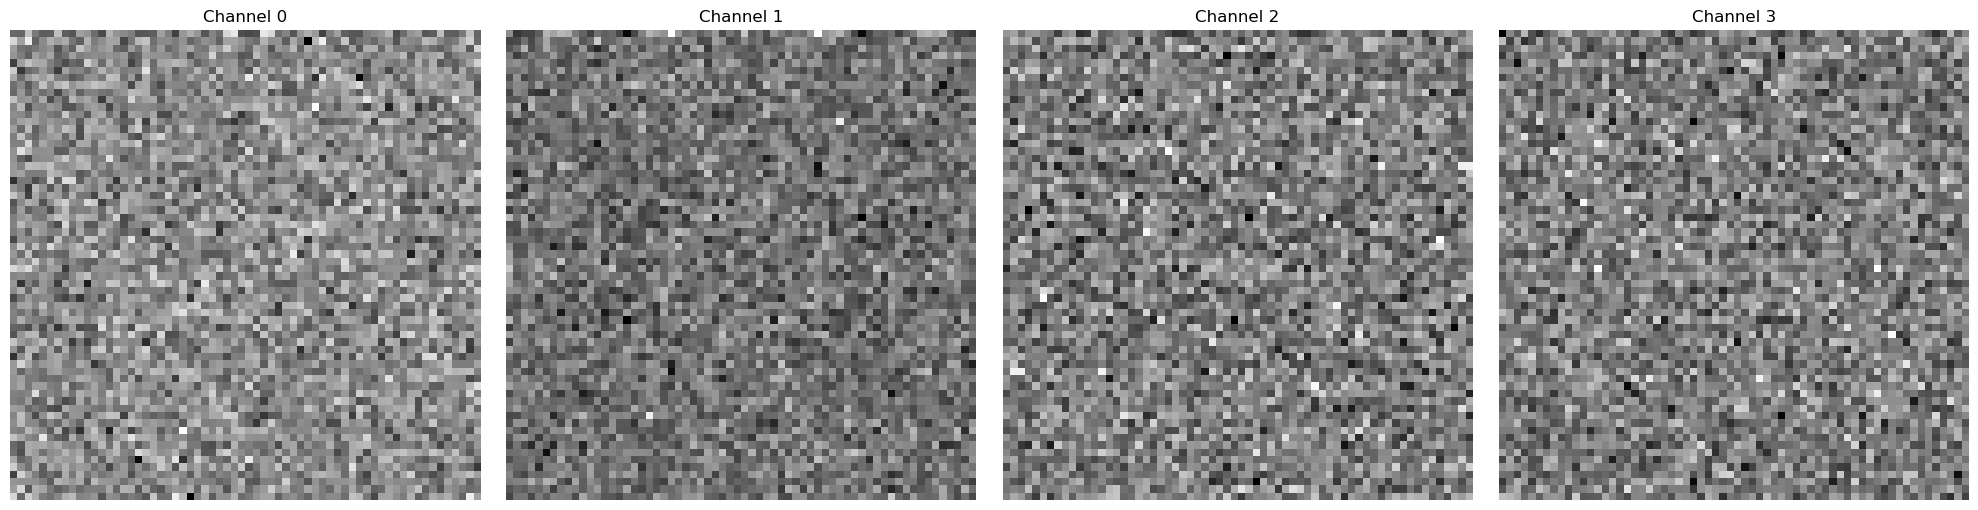

Pattern: zeros


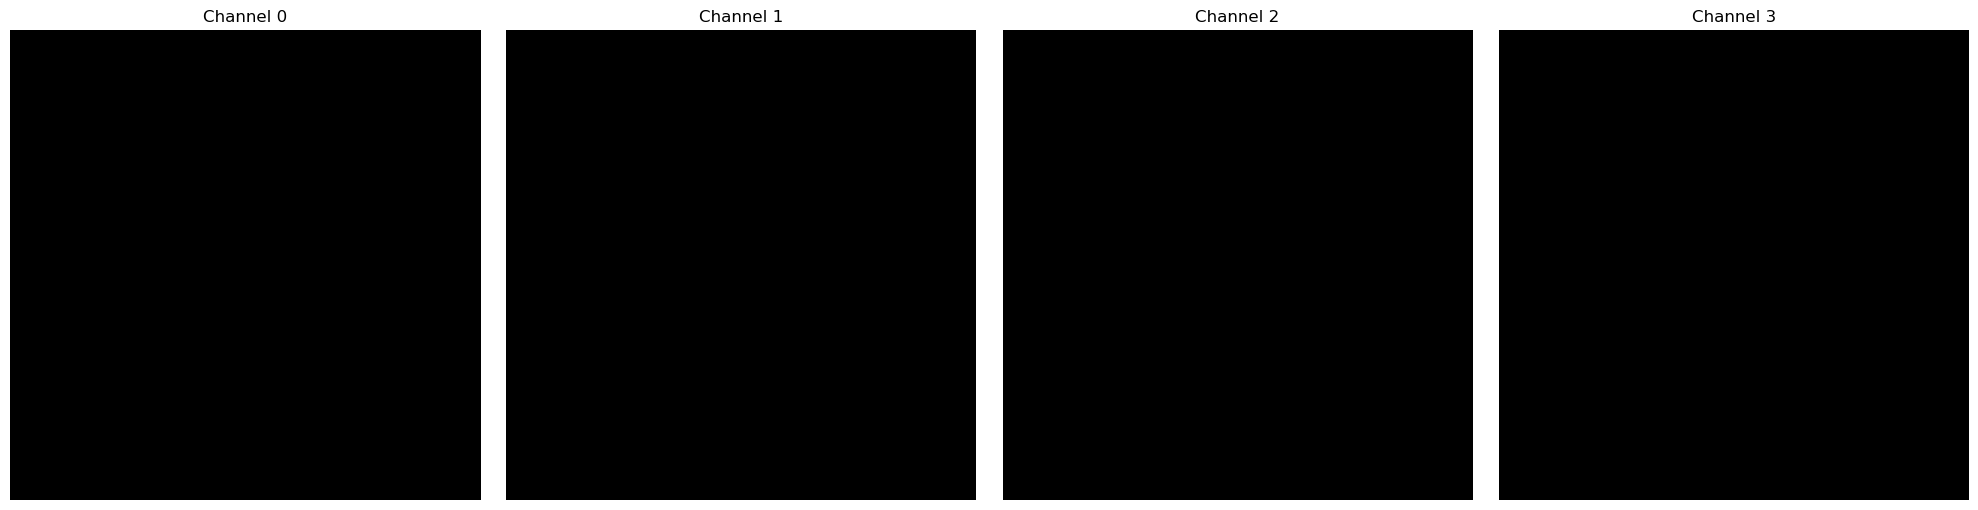

Pattern: const


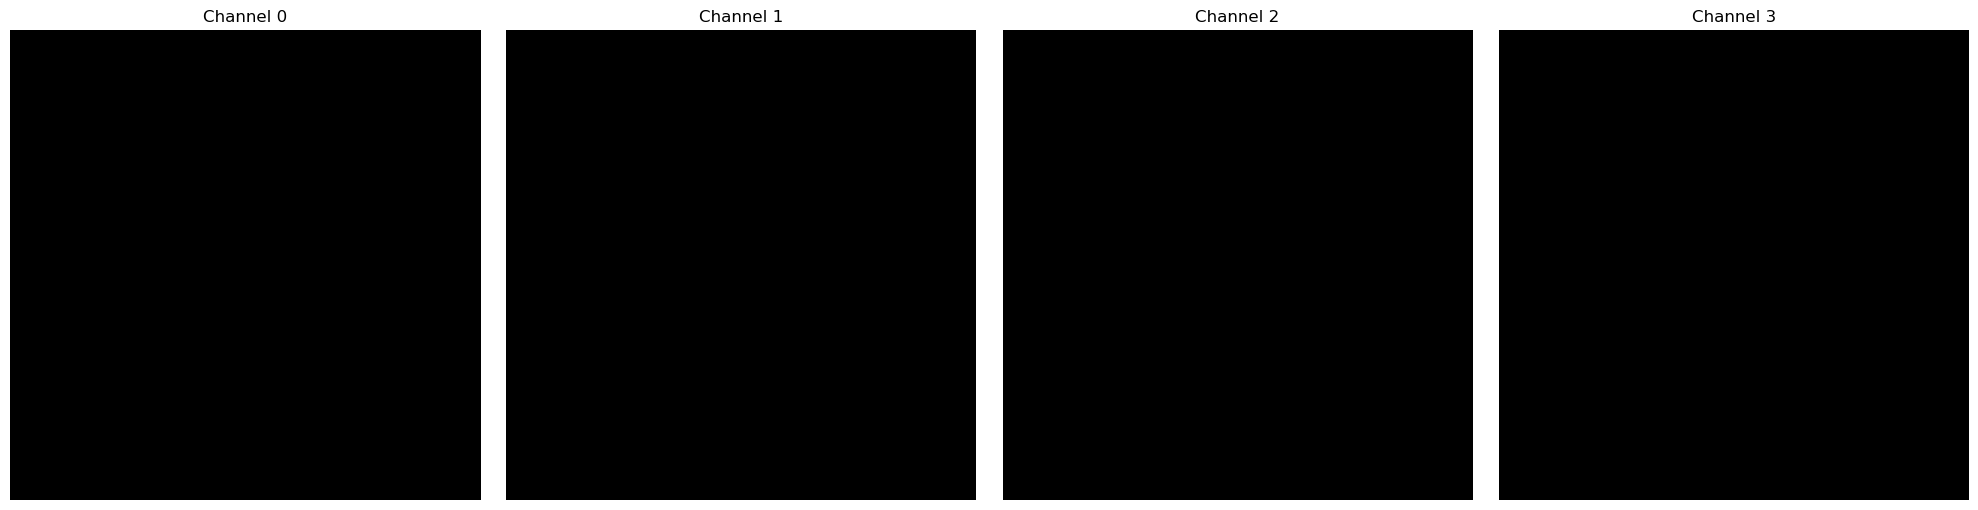

Pattern: seed_rand


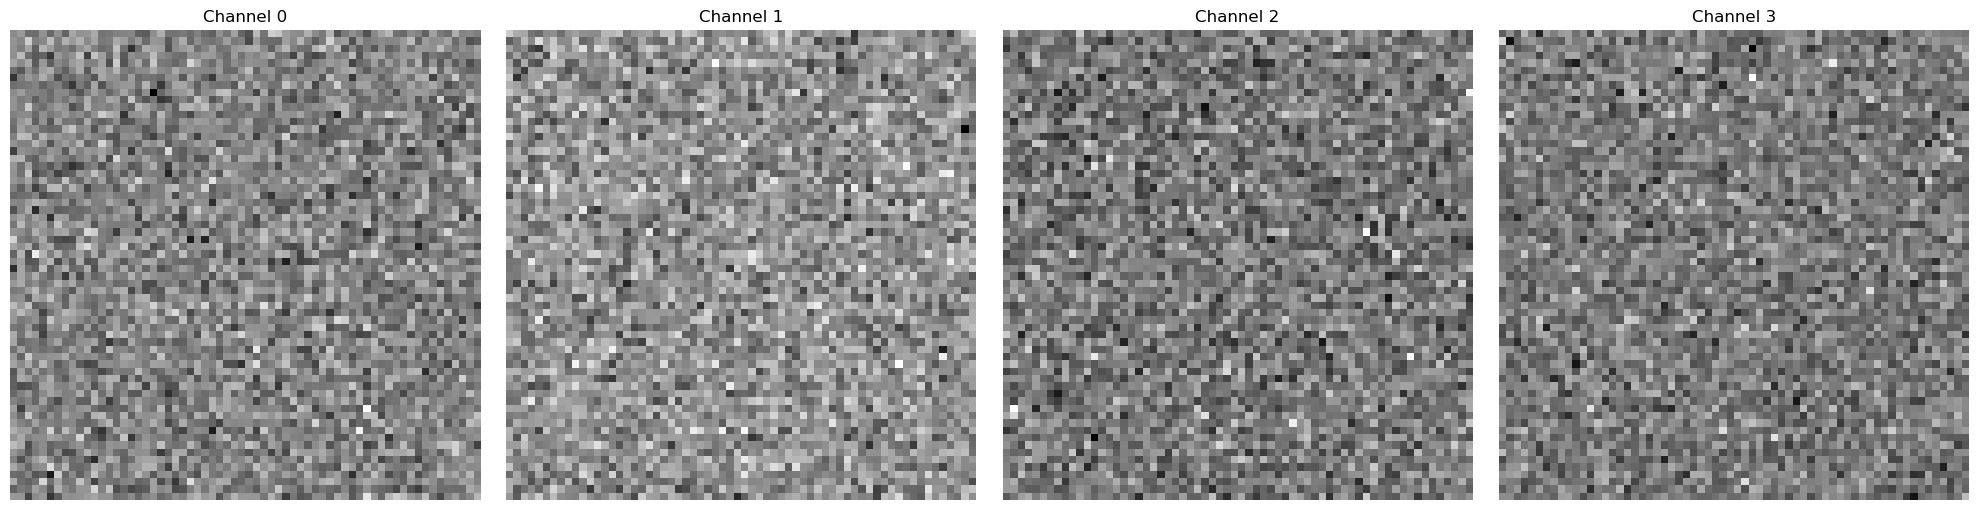

Pattern: seed_zeros


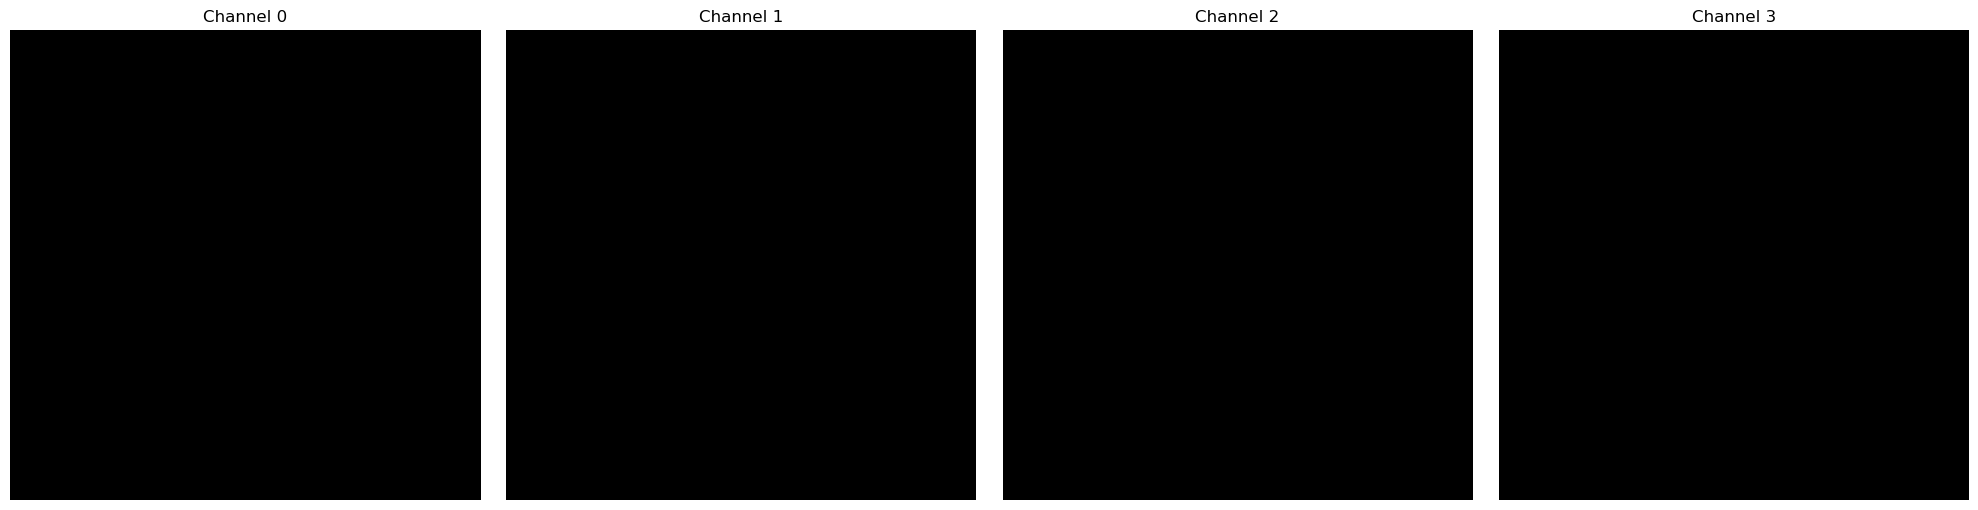

Pattern: seed_ring


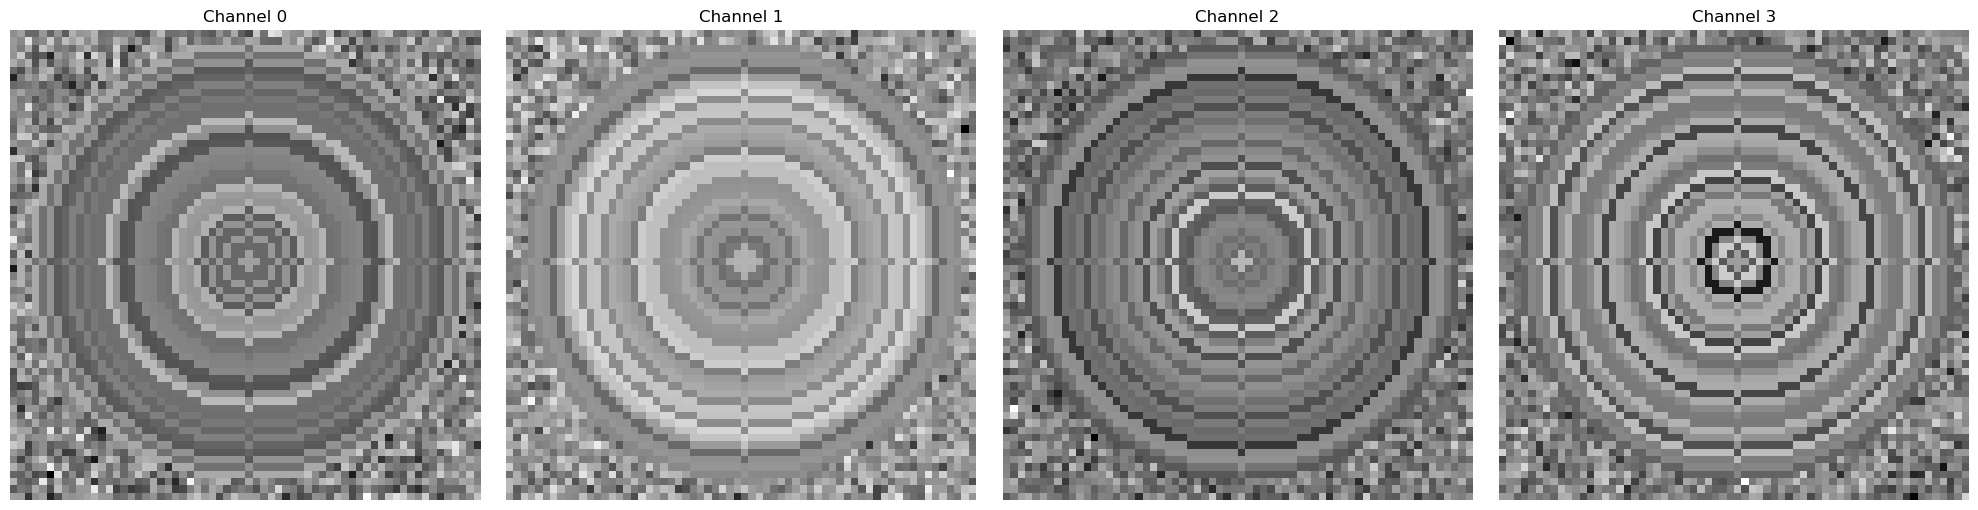

Pattern: ring


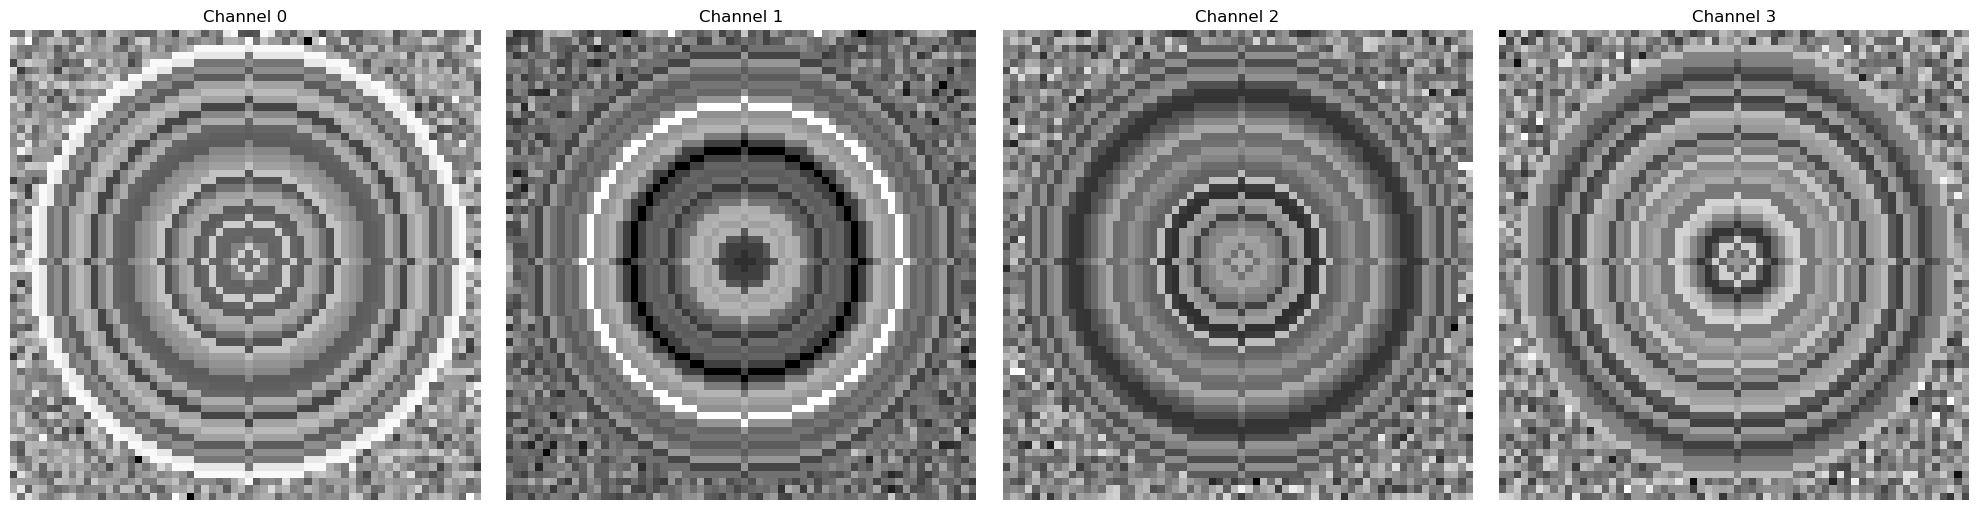

In [10]:
# Go through all the watermarking patterns to visualise them
for w_pattern in [
    "rand",
    "zeros",
    "const",
    "seed_rand",
    "seed_zeros",
    "seed_ring",
    "ring",
]:
    print(f"Pattern: {w_pattern}")
    vis_patch = get_watermarking_pattern(
        pipe,
        w_seed=w_seed,
        w_pattern=w_pattern,
        w_radius=w_radius,
        device=device,
        shape=None,
    )
    visualise_noise(vis_patch[0])

In [11]:
# Generation parameters
gen_seed = 0
num_images = 1
guidance_scale = 7.5
num_inference_steps = 50
image_length = 512
set_random_seed(gen_seed)

# 3. Prepare latent for generation

In [12]:
i = 5 # Select an index from the dataset to generate the image

In [13]:
current_prompt = dataset[i][prompt_key]
print(f"Prompt for generation: {current_prompt}")

Prompt for generation: american portrait of one retrofuturistic assassin surrounded by advanced brutalist architecture. highly detailed science fiction, rich colors, high contrast, gloomy atmosphere, dark background. trending on artstation an ultrafine hyperdetailed colorfull illustration by tsutomu nihei by emil melmoth, gustave dore, craig mullins, yoji shinkawa, luis royo, zaha hadid, pete morbacher, female, feminine, art deco, new baroque, intricate linework


## 3.1 Without watermarking

### Visualize the initial latents (noise) without watermarking

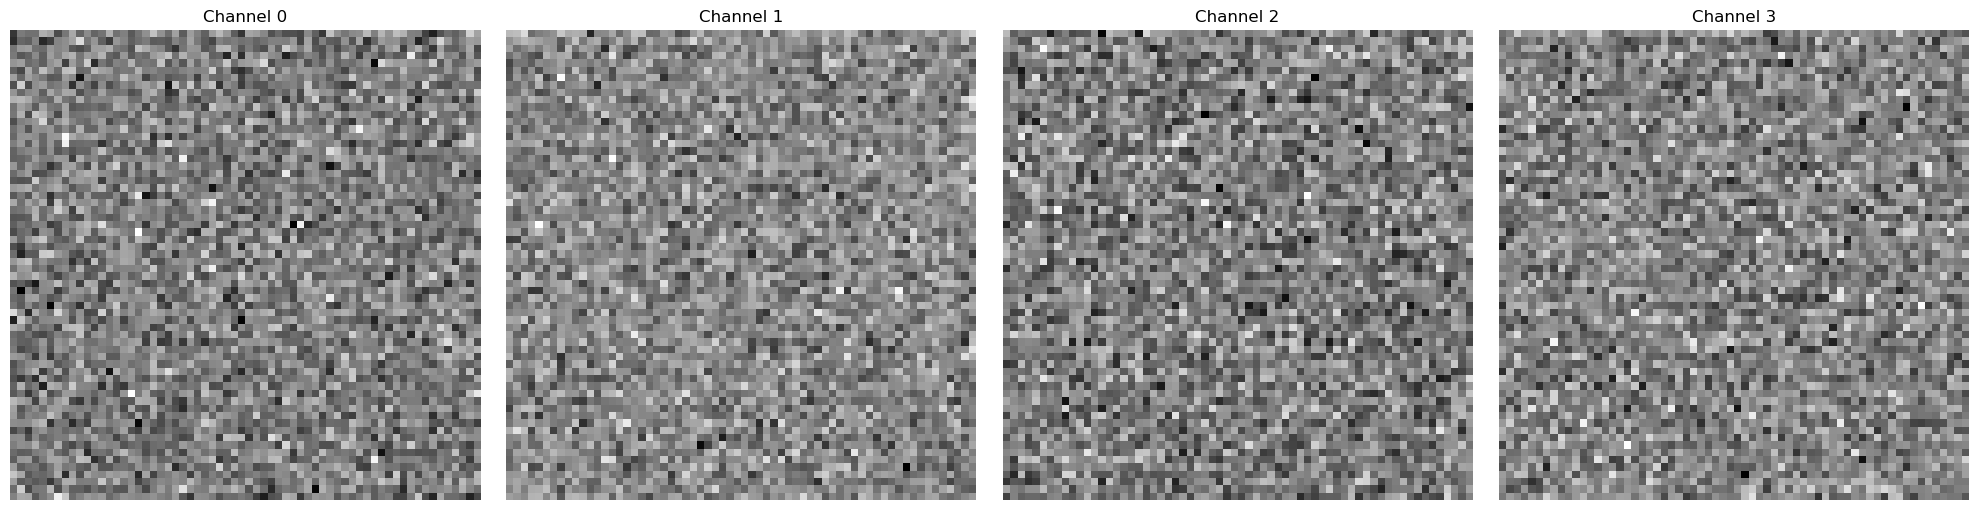

In [14]:
init_latents_no_w = pipe.get_random_latents()
visualise_noise(init_latents_no_w[0])

#### Generate the image from the initial latents without watermarking (normal pipeline)

In [15]:
outputs_no_w = pipe(
    current_prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,  # how strongly to follow the prompt
    num_inference_steps=num_inference_steps,  # how many steps of denoising to do
    height=image_length,
    width=image_length,
    latents=init_latents_no_w,
)
orig_image_no_w = outputs_no_w.images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (93 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['morbacher , female , feminine , art deco , new baroque , intricate linework']


  0%|          | 0/50 [00:00<?, ?it/s]

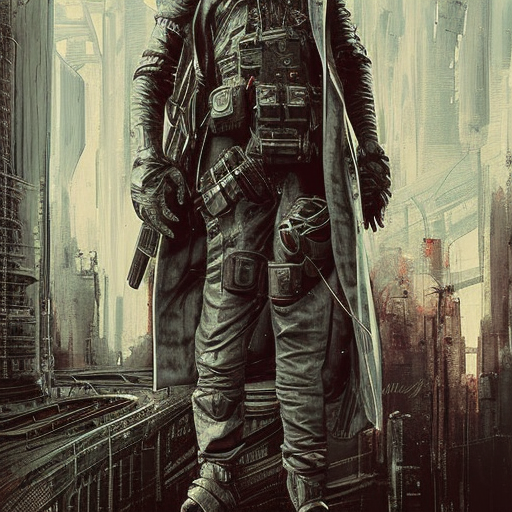

In [16]:
orig_image_no_w

## 3.2 With watermarking

In [17]:
# Use the same latent for generating the image with watermark
if init_latents_no_w is None:
    set_random_seed(gen_seed)
    init_latents_w = pipe.get_random_latents()
else:
    init_latents_w = copy.deepcopy(init_latents_no_w)

In [18]:
def get_watermarking_mask(
    init_latents_w,
    w_mask_shape: str,
    w_channel: int,
    w_radius: float,
    device: str,
):
    """
    Generate a watermarking mask based on the specified parameters.
    Parameters:
        - init_latents_w: The initial latents with watermarking.
        - w_mask_shape: The shape of the watermarking mask (e.g., "circle", "square").
        - w_channel: The channel to apply the watermarking mask to (-1 for all channels).
        - w_radius: The radius for the watermarking mask.
        - device: The device to use for computation (e.g., "cuda" or "cpu").
    Returns:
        - watermarking_mask: The generated watermarking mask.
    """
    watermarking_mask = torch.zeros(init_latents_w.shape, dtype=torch.bool).to(device)

    if w_mask_shape == "circle":
        np_mask = circle_mask(init_latents_w.shape[-1], r=w_radius)
        torch_mask = torch.tensor(np_mask).to(device)

        if w_channel == -1:
            # all channels
            watermarking_mask[:, :] = torch_mask
        else:
            watermarking_mask[:, w_channel] = torch_mask
    elif w_mask_shape == "square":
        anchor_p = init_latents_w.shape[-1] // 2
        if w_channel == -1:
            # all channels
            watermarking_mask[
                :,
                :,
                anchor_p - w_radius : anchor_p + w_radius,
                anchor_p - w_radius : anchor_p + w_radius,
            ] = True
        else:
            watermarking_mask[
                :,
                w_channel,
                anchor_p - w_radius : anchor_p + w_radius,
                anchor_p - w_radius : anchor_p + w_radius,
            ] = True
    elif w_mask_shape == "no":
        pass
    else:
        raise NotImplementedError(f"w_mask_shape: {w_mask_shape}")

    return watermarking_mask

## 🧱 Watermarking Mask ($\mathcal{M}$) Generation

The `get_watermarking_mask(...)` function constructs a **binary mask** (a tensor of `True`/`False` values) that determines **where** in the latent space the watermark should be applied during generation.

This mask is used to **localize perturbations** to specific spatial regions of the latent tensor $x_T \in \mathbb{R}^{B \times C \times H \times W}$, allowing for controlled watermark injection.

---

### 🧩 Supported Mask Shapes

| Shape      | Description                                                | Behavior                                                              |
| ---------- | ---------------------------------------------------------- | --------------------------------------------------------------------- |
| `"circle"` | Applies a circular region mask at the spatial center       | Mask created using `circle_mask(...)` from NumPy                      |
| `"square"` | Applies a square region centered in the spatial dimensions | Square of size $2 \times \text{radius} \times 2 \times \text{radius}$ |
| `"no"`     | Disables watermarking mask                                 | Returns an all-false mask                                             |

---

### 🧠 Channel Control (`w_channel`)

* If `w_channel = -1`: The mask is **broadcasted to all channels** in the latent.
* If `w_channel = c`: The mask is applied **only to the c-th channel**.

This allows testing different watermarking strategies such as:

* Injecting only in a **single semantic channel** (e.g., edge, texture),
* Applying noise across **all feature maps** equally.

---

### 📌 Output

Returns a boolean tensor `watermarking_mask` of the same shape as `init_latents_w`, where:

* `True` indicates positions that will be **perturbed with watermark noise**.
* `False` indicates positions that remain untouched.

In [19]:
watermarking_mask = get_watermarking_mask(
    init_latents_w,
    w_mask_shape=w_mask_shape,
    w_channel=w_channel,
    w_radius=w_radius, 
    device=device,
)

### Visualise the watermarking mask

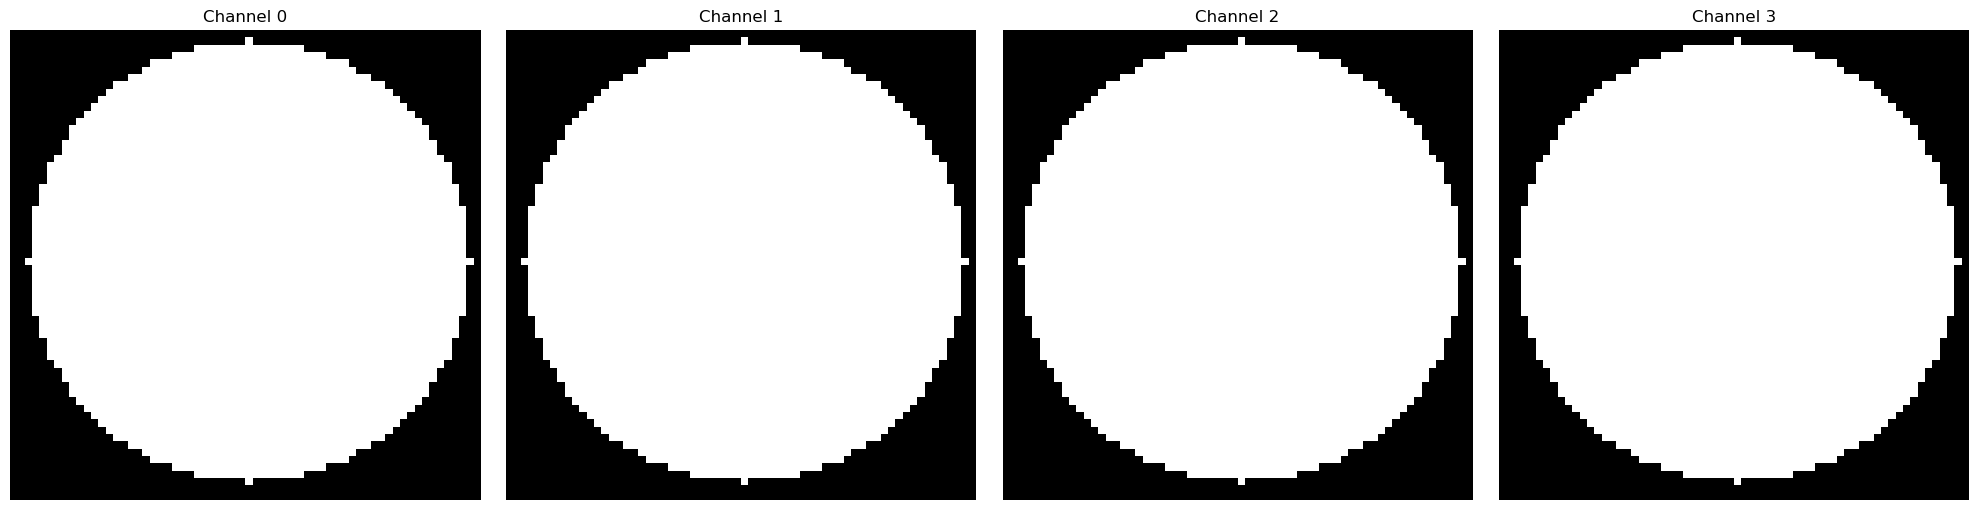

In [20]:
visualise_noise(watermarking_mask[0].float()) 

#### Watermarking can also be applied to only one channel

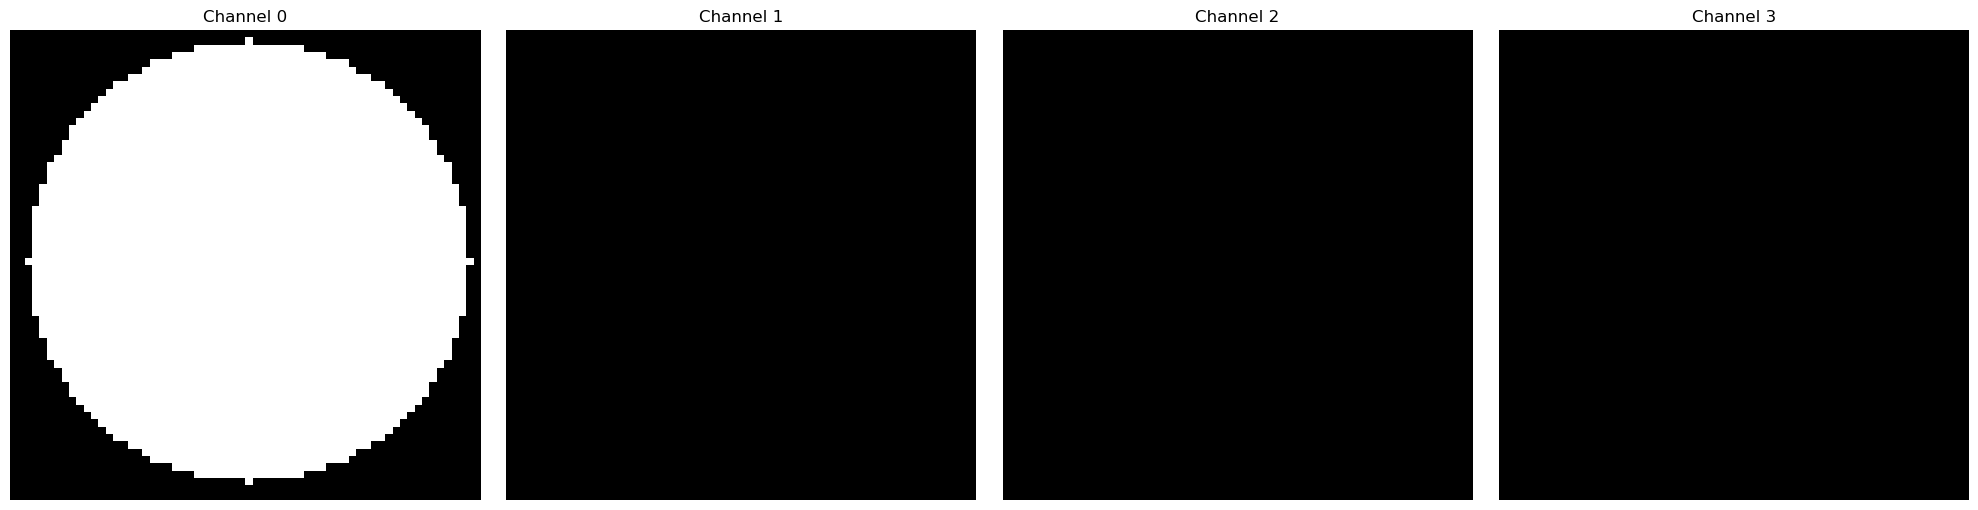

In [37]:
visualise_noise(get_watermarking_mask(
    init_latents_w,
    w_mask_shape=w_mask_shape,
    w_channel=0,
    w_radius=w_radius, 
    device=device,
)[0].float())

In [ ]:
def inject_watermark(init_latents_w, watermarking_mask, gt_patch, w_injection: str):
    """
    Inject the watermark into the latents.
    Parameters:
        - init_latents_w: The initial latents with watermarking.
        - watermarking_mask: The mask indicating where to inject the watermark. (in the Fourier domain)
        - gt_patch: The watermark pattern to be injected.
        - w_injection: The method of watermark injection (e.g., "complex", "seed").
    Returns:
        - init_latents_w: The latents with the watermark injected.
    """
    # Perform FFT on the latents
    init_latents_w_fft = torch.fft.fftshift(torch.fft.fft2(init_latents_w), dim=(-1, -2))

    # Inject the watermark into the latents in FFT domain
    if w_injection == 'complex':
        init_latents_w_fft[watermarking_mask] = gt_patch[watermarking_mask].clone()
    elif w_injection == 'seed':
        init_latents_w[watermarking_mask] = gt_patch[watermarking_mask].clone()
        return init_latents_w
    else:
        NotImplementedError(f'w_injection: {w_injection}')

    # Perform inverse FFT to get the latents with watermark
    init_latents_w = torch.fft.ifft2(torch.fft.ifftshift(init_latents_w_fft, dim=(-1, -2))).real

    return init_latents_w

## 💧 Watermark Injection into Latents

The `inject_watermark(...)` function inserts a **watermark pattern** into a latent tensor $x_T \in \mathbb{R}^{B \times C \times H \times W}$ using a specified injection strategy and spatial mask. This step finalizes the preparation of watermarked noise for diffusion-based generation.

### 🔧 Parameters

* **`init_latents_w`**: The initial latent tensor intended to carry the watermark.
* **`watermarking_mask`**: A boolean tensor specifying which elements of the latent should be modified.
* **`gt_patch`**: The target watermark pattern, generated via `get_watermarking_pattern(...)`.
* **`w_injection`** (`str`): The injection method. Currently supports:

  * `"complex"`: Inject in the **Fourier domain**.
  * `"seed"`: Inject directly in the **spatial domain**.

---

### 💡 Injection Modes

| Injection Mode | Domain      | Description                                                                                                                                                             |
| -------------- | ----------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `"complex"`    | **Fourier** | Applies 2D FFT to the latent, injects watermark in frequency space (using mask), then performs inverse FFT. This is the **core method used in Tree-Ring watermarking**. |
| `"seed"`       | Spatial     | Injects `gt_patch` directly into `init_latents_w` using the binary mask in the spatial domain. This is simpler and used mainly for baselines or ablation studies.       |

---

### 🧠 Process Overview (Fourier Injection)

For the `"complex"` mode:

1. **Forward FFT**:
   The latent is transformed into the frequency domain:

   $$
   \mathcal{F}(x_T) = \text{fftshift}(\text{fft2}(x_T))
   $$

2. **Watermark Injection** (already in Fourier space):

   $$
   \mathcal{F}(x_T)_i \gets k^*_i \quad \text{for } i \in \mathcal{M}
   $$

   Where:

   * $\mathcal{F}(x_T)$ is the FFT of the latent,
   * $k^*_i$ comes from the watermark pattern `gt_patch`,
   * $\mathcal{M}$ is defined by `watermarking_mask`.

3. **Inverse FFT**:
   Transforms the modified latent back into the spatial domain:

   $$
   x_T^\text{marked} = \text{Re}\left[ \text{ifft2}(\text{ifftshift}(\mathcal{F}(x_T))) \right]
   $$

---

### 📌 Output

Returns a modified latent tensor `init_latents_w`:

* In the **Fourier-injected case**, this is a spatial-domain latent with a hidden watermark.
* In the **seed-injected case**, the spatial values are directly overwritten in-place.

This tensor is then passed into the Stable Diffusion pipeline to generate the watermarked image.



In [22]:
init_latents_w = inject_watermark(
    init_latents_w,
    watermarking_mask,
    gt_patch,
    w_injection=w_injection,
)

### Visualised the watermarked latents (No pattern can be seen in spatial domain)

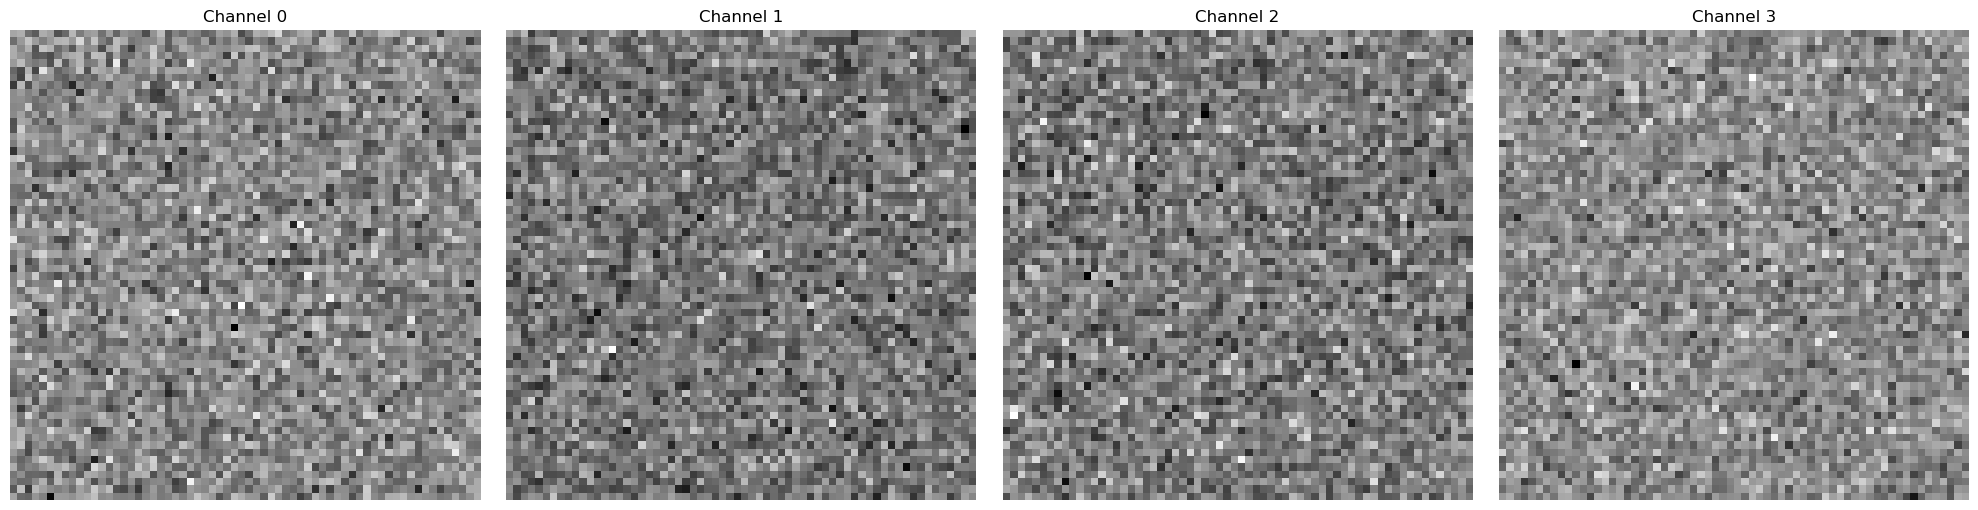

In [ ]:
visualise_noise(init_latents_w[0])

In [24]:
outputs_w = pipe(
    current_prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    latents=init_latents_w,
)
orig_image_w = outputs_w.images[0]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['morbacher , female , feminine , art deco , new baroque , intricate linework']


  0%|          | 0/50 [00:00<?, ?it/s]

### Compare watermarked and non-watermarked images

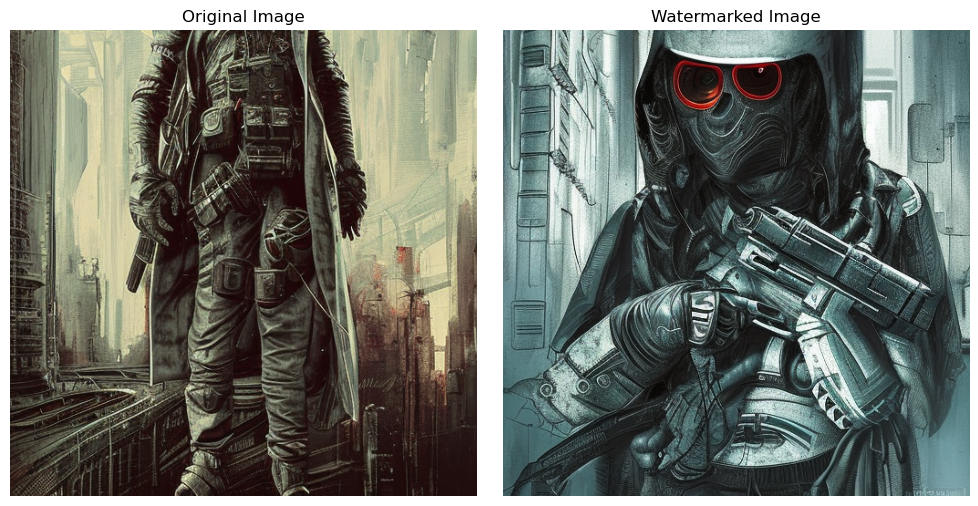

In [25]:
# visulise the original image and the watermarked image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_image_no_w)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(orig_image_w)
axes[1].set_title("Watermarked Image")
axes[1].axis("off")
plt.tight_layout()
plt.show()


# 4. Attack the images

In [26]:
# Attacking parameters
r_degree = 15
jpeg_ratio = None 
crop_scale = 0.95
crop_ratio = 0.95
gaussian_blur_r = 0.2
gaussian_std = 0.003
brightness_factor = None 
rand_aug = 0

test_num_inference_steps = 50
reference_model = None
reference_model_pretrain = None
run_name = "test"

In [27]:
from torchvision import transforms
from PIL import Image, ImageFilter

def image_distortion(
    img1,
    img2,
    seed,
    r_degree,
    jpeg_ratio,
    crop_scale,
    crop_ratio,
    gaussian_blur_r,
    gaussian_std,
    brightness_factor,
):
    """
    Apply various image distortions to two images.
    Parameters:
        - img1: The first image to be distorted.
        - img2: The second image to be distorted.
        - seed: The seed for random number generation.
        - r_degree: The degree of rotation to apply to the images.
        - jpeg_ratio: The JPEG compression ratio to apply to the images.
        - crop_scale: The scale for random cropping.
        - crop_ratio: The aspect ratio for random cropping.
        - gaussian_blur_r: The radius for Gaussian blur.
        - gaussian_std: The standard deviation for Gaussian noise.
        - brightness_factor: The factor for brightness adjustment.
    Returns:
        - img1: The distorted first image.
        - img2: The distorted second image.
    """
    if r_degree is not None:
        img1 = transforms.RandomRotation((r_degree, r_degree))(img1)
        img2 = transforms.RandomRotation((r_degree, r_degree))(img2)

    if jpeg_ratio is not None:
        img1.save(f"tmp_{jpeg_ratio}_{run_name}.jpg", quality=jpeg_ratio)
        img1 = Image.open(f"tmp_{jpeg_ratio}_{run_name}.jpg")
        img2.save(f"tmp_{jpeg_ratio}_{run_name}.jpg", quality=jpeg_ratio)
        img2 = Image.open(f"tmp_{jpeg_ratio}_{run_name}.jpg")

    if crop_scale is not None and crop_ratio is not None:
        set_random_seed(seed)
        img1 = transforms.RandomResizedCrop(
            img1.size,
            scale=(crop_scale, crop_scale),
            ratio=(crop_ratio, crop_ratio),
        )(img1)
        set_random_seed(seed)
        img2 = transforms.RandomResizedCrop(
            img2.size,
            scale=(crop_scale, crop_scale),
            ratio=(crop_ratio, crop_ratio),
        )(img2)

    if gaussian_blur_r is not None:
        img1 = img1.filter(ImageFilter.GaussianBlur(radius=gaussian_blur_r))
        img2 = img2.filter(ImageFilter.GaussianBlur(radius=gaussian_blur_r))

    if gaussian_std is not None:
        img_shape = np.array(img1).shape
        g_noise = np.random.normal(0, gaussian_std, img_shape) * 255
        g_noise = g_noise.astype(np.uint8)
        img1 = Image.fromarray(np.clip(np.array(img1) + g_noise, 0, 255))
        img2 = Image.fromarray(np.clip(np.array(img2) + g_noise, 0, 255))

    if brightness_factor is not None:
        img1 = transforms.ColorJitter(brightness=brightness_factor)(img1)
        img2 = transforms.ColorJitter(brightness=brightness_factor)(img2)

    return img1, img2

## 🎨 `image_distortion(...)`: Attack Watermarking Pattern via Image Distortion

The `image_distortion(...)` function applies a series of **controlled perturbations** to two input images using consistent randomness (via a seed). These distortions simulate realistic degradations, and can be used to test watermark robustness or image reconstruction fidelity.

---

### ⚙️ Transformations Applied

Each transform is applied **in sequence** and **symmetrically** to both images:

| Step | Transformation        | Description                                                                                        |
| ---- | --------------------- | -------------------------------------------------------------------------------------------------- |
| 1️⃣  | **Rotation**          | Rotates both images by exactly `r_degree`.                                                         |
| 2️⃣  | **JPEG Compression**  | Saves and reloads each image using the specified `jpeg_ratio` for lossy compression.               |
| 3️⃣  | **Random Cropping**   | Applies `RandomResizedCrop` with fixed seed to ensure the **same crop is applied** to both images. |
| 4️⃣  | **Gaussian Blur**     | Blurs both images using the specified blur radius.                                                 |
| 5️⃣  | **Gaussian Noise**    | Adds pixel-wise random Gaussian noise to simulate image corruption.                                |
| 6️⃣  | **Brightness Jitter** | Adjusts brightness using `ColorJitter` for consistent lighting perturbation.                       |

In [28]:
# Attack the image
orig_image_no_w_auged, orig_image_w_auged = image_distortion(
    orig_image_no_w,
    orig_image_w,
    gen_seed,
    r_degree=r_degree,
    jpeg_ratio=jpeg_ratio,
    crop_scale=crop_scale,
    crop_ratio=crop_ratio,
    gaussian_blur_r=gaussian_blur_r,
    gaussian_std=gaussian_std,
    brightness_factor=brightness_factor,
)

## Visualise the distored images

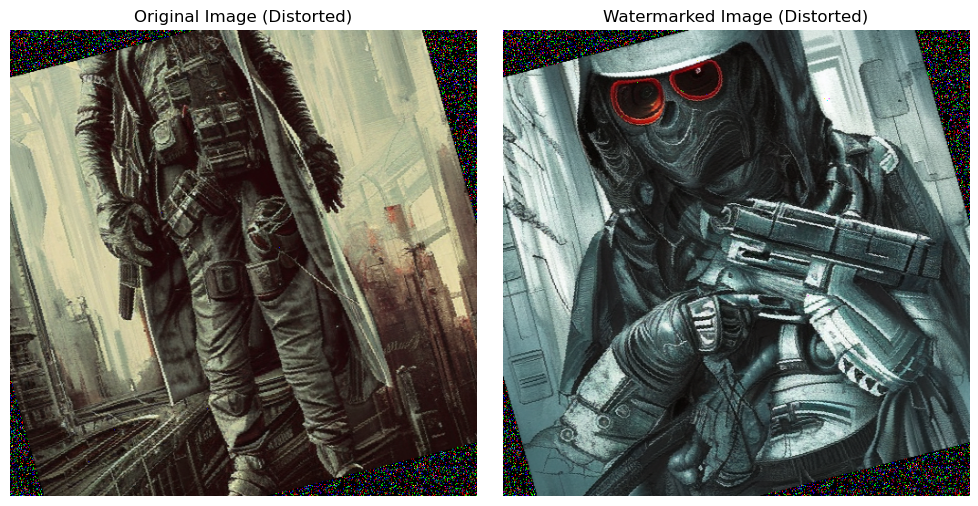

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig_image_no_w_auged)
axes[0].set_title("Original Image (Distorted)")
axes[0].axis("off")
axes[1].imshow(orig_image_w_auged)
axes[1].set_title("Watermarked Image (Distorted)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [30]:
def transform_img(image, target_size=512):
    tform = transforms.Compose(
        [
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ]
    )
    image = tform(image)
    return 2.0 * image - 1.0

# 5. From Image to Latents

In [31]:
# reverse img without watermarking
img_no_w = transform_img(orig_image_no_w_auged).unsqueeze(0).to(text_embeddings.dtype).to(device)
image_latents_no_w = pipe.get_image_latents(img_no_w, sample=False)

reversed_latents_no_w = pipe.forward_diffusion(
    latents=image_latents_no_w,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=test_num_inference_steps,
)

# reverse img with watermarking
img_w = transform_img(orig_image_w_auged).unsqueeze(0).to(text_embeddings.dtype).to(device)
image_latents_w = pipe.get_image_latents(img_w, sample=False)

reversed_latents_w = pipe.forward_diffusion(
    latents=image_latents_w,
    text_embeddings=text_embeddings,
    guidance_scale=1,
    num_inference_steps=test_num_inference_steps,
)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def eval_watermark(
    reversed_latents_no_w,
    reversed_latents_w,
    watermarking_mask,
    gt_patch,
    w_measurement: str,
):
    """
    Evaluate the watermarking performance based on the specified measurement method.
    Parameters:
        - reversed_latents_no_w: The latents without watermarking.
        - reversed_latents_w: The latents with watermarking.
        - watermarking_mask: The mask indicating the watermarking area.
        - gt_patch: The watermark pattern.
        - w_measurement: The method of watermark measurement (e.g., "l1", "complex").
    Returns:
        - no_w_metric: The measurement result for the latents without watermarking.
        - w_metric: The measurement result for the latents with watermarking.
    """

    if "complex" in w_measurement:
        """
        Measurement in FFT domain: It goes into the FFT to obtain the pattern.
        """
        reversed_latents_no_w_fft = torch.fft.fftshift(
            torch.fft.fft2(reversed_latents_no_w), dim=(-1, -2)
        )
        reversed_latents_w_fft = torch.fft.fftshift(
            torch.fft.fft2(reversed_latents_w), dim=(-1, -2)
        )
        target_patch = gt_patch
    elif "seed" in w_measurement:
        """
        Measurement in real domain: It stays in the real domain to obtain the pattern.
        """
        reversed_latents_no_w_fft = reversed_latents_no_w
        reversed_latents_w_fft = reversed_latents_w
        target_patch = gt_patch
    else:
        raise NotImplementedError(f"w_measurement: {w_measurement}")

    if "l1" in w_measurement:
        """
        L1 measurement: compare the pattern in the real/FFT domain on the *mask*.
        """
        no_w_metric = (
            torch.abs(
                reversed_latents_no_w_fft[watermarking_mask]
                - target_patch[watermarking_mask]
            )
            .mean()
            .item()
        )
        w_metric = (
            torch.abs(
                reversed_latents_w_fft[watermarking_mask]
                - target_patch[watermarking_mask]
            )
            .mean()
            .item()
        )

        ### Implement PSNR
    else:
        raise NotImplementedError(f"w_measurement: {w_measurement}")

    return no_w_metric, w_metric

## 📏 `eval_watermark(...)`: Watermark Evaluation Function

The `eval_watermark(...)` function measures how well a watermark is preserved or detectable in latent representations. It compares both **watermarked** and **non-watermarked** latents against a known **ground truth watermark pattern** (`gt_patch`) within a defined **mask region**.

---

### 🧭 Supported Evaluation Modes

`w_measurement` is a string that defines **both the domain** and **the comparison metric**.

| Domain      | Description                                                                                                   |
| ----------- | ------------------------------------------------------------------------------------------------------------- |
| `"complex"` | Compares in the **Fourier domain** using `fft2` + `fftshift`. Used for watermark injected in frequency space. |
| `"seed"`    | Compares in the **spatial domain** (real space). Used for seed-based watermarking or ablations.               |

---

### 📐 What It Measures

For both `reversed_latents_no_w` and `reversed_latents_w`, the function computes:

$$
\text{L1\_distance} = \frac{1}{|\mathcal{M}|} \sum_{i \in \mathcal{M}} \left| x_i - k^*_i \right|
$$

Where:

* $\mathcal{M}$ is the watermarking mask,
* $x_i$ is the latent value (in spatial or Fourier domain),
* $k^*_i$ is the watermark key (from `gt_patch`).

This yields two scalar values:

* **`no_w_metric`**: Distance for the non-watermarked case
* **`w_metric`**: Distance for the watermarked case

A strong watermark should yield:

* `no_w_metric` ≫ `w_metric`

---

### 📌 Output

```python
no_w_metric, w_metric = eval_watermark(...)
```

Where both are floats representing the L1 distance between the latent (in real or FFT domain) and the watermark patch, masked to the target region.


# 5. Evaluate the watermarking performance through measuring the distance of the image to the gt_pattern.

In [33]:
# Perform evaluation
no_w_metric, w_metric = eval_watermark(
    reversed_latents_no_w,
    reversed_latents_w,
    watermarking_mask,
    gt_patch,
    w_measurement=w_measurement,
)

In [39]:
print(
    f"""The distance of the `gt_pattern`to the latent of the unwatermarked image is {no_w_metric}.
And, the distance of the `gt_pattern` to the latent of the watermarked image is {w_metric}.
If the distance of the watermarked image is smaller than that of the unwatermarked image, it means that the watermarking performs reasonably."""
)

The distance of the `gt_pattern`to the latent of the unwatermarked image is 79.9375.
And, the distance of the `gt_pattern` to the latent of the watermarked image is 79.1875.
If the distance of the watermarked image is smaller than that of the unwatermarked image, it means that the watermarking performs reasonably.


1. access the latent space -> inject watermarking.
2. 